### Session 1: Model validning
Place the program time_double_string.py and test_correlation.py in the same directory of this file.<br>
Download the geomagnetic indices data (symh_sme_20xx.csv), the satellite coordinates data (coord_20xx?.csv), and the RBSPICE spin-averaged flux data (rbspice?_p_20xx.csv) and place them in the directory of dir0 (self-defined). Then run the code below.

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
# import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from datetime import datetime
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from time_double_string import time_double,time_string
from test_correlation import lws_rbspice_loss_function_history, lws_rbspice_correlation
np.random.seed(46)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # This is to disable GPU

## Load geomagnetic indices from 2012-10-01 to 2018-12-31 (we need the history 
#  of geomagnetic indices to predict particle fluxes)
#  Load satellite orbit data and rbspice spinaveraged proton flux from 2013-01-01 
#  to 2018-12-31
dir0="C:/Users/Jimmy/OneDrive/Documents/work/lws/"
dir0="/Users/ljx/OneDrive/Documents/work/lws/"
dir0="C:/Users/Jimmy/iCloudDrive/Documents/workspace/python/lws/"
dir0="/Users/ljx/Documents/workspace/python/lws/"
#dir0="/rcpann/"
probes=['a','b']#,'b']
n_probes=len(probes)

df_symh    = pd.read_csv(dir0+'lws_data/geomag_2012_2018.csv')
df_coord_a = pd.read_csv(dir0+'lws_data/coord_2013_2018_a.csv')
df_coord_b = pd.read_csv(dir0+'lws_data/coord_2013_2018_b.csv')
df_coord   = pd.concat([df_coord_a,df_coord_b],ignore_index=True)
df_flux_a  = pd.read_csv(dir0+'lws_data/rbspice_p_2013_2018_a.csv')
df_flux_b  = pd.read_csv(dir0+'lws_data/rbspice_p_2013_2018_b.csv')

# Mark data that should not be used
# Use Probe A data after 2016-11-01
# Use Probe B data before 2016-11-01
ind_a_bad = np.where(df_flux_a['Datetime']<"2016-11-01")[0]
ind_b_bad = np.where((df_flux_b['Datetime']>"2016-11-01") & (df_flux_b['Datetime']<"2018-01-01"))[0]
df_flux_a.iloc[ind_a_bad,1:]=np.nan
df_flux_b.iloc[ind_b_bad,1:]=np.nan

# Restrict data to L>2.5, and mark data measured at L<2.5 as bad
ind_a_bad_L25 = np.where(df_coord_a['L']<2.5)[0]
ind_b_bad_L25 = np.where(df_coord_b['L']<2.5)[0]
df_flux_a.iloc[ind_a_bad_L25,1:]=np.nan
df_flux_b.iloc[ind_b_bad_L25,1:]=np.nan

df_flux    = pd.concat([df_flux_a,df_flux_b],ignore_index=True)
del df_coord_a, df_coord_b, df_flux_a, df_flux_b


In [2]:
df_flux

,Datetime,45,55,67,82,99,121,148,181,220,269,328,400,489,598
0,2013-01-01 00:02:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01 00:07:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01 00:12:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01 00:17:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01 00:22:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262011,2018-12-31 23:37:30,5.954,6.223,6.172,6.145,6.103,6.295,6.541,6.824,6.971,6.958,6.890,6.780,6.599,6.378
1262012,2018-12-31 23:42:30,5.896,6.019,5.947,5.899,5.938,6.163,6.451,6.766,6.954,6.969,6.937,6.855,6.699,6.497
1262013,2018-12-31 23:47:30,5.812,5.834,5.760,5.713,5.809,6.063,6.367,6.696,6.921,6.958,6.961,6.906,6.771,6.596
1262014,2018-12-31 23:52:30,5.799,5.775,5.639,5.628,5.712,5.938,6.258,6.596,6.855,6.919,6.950,6.916,6.800,6.652


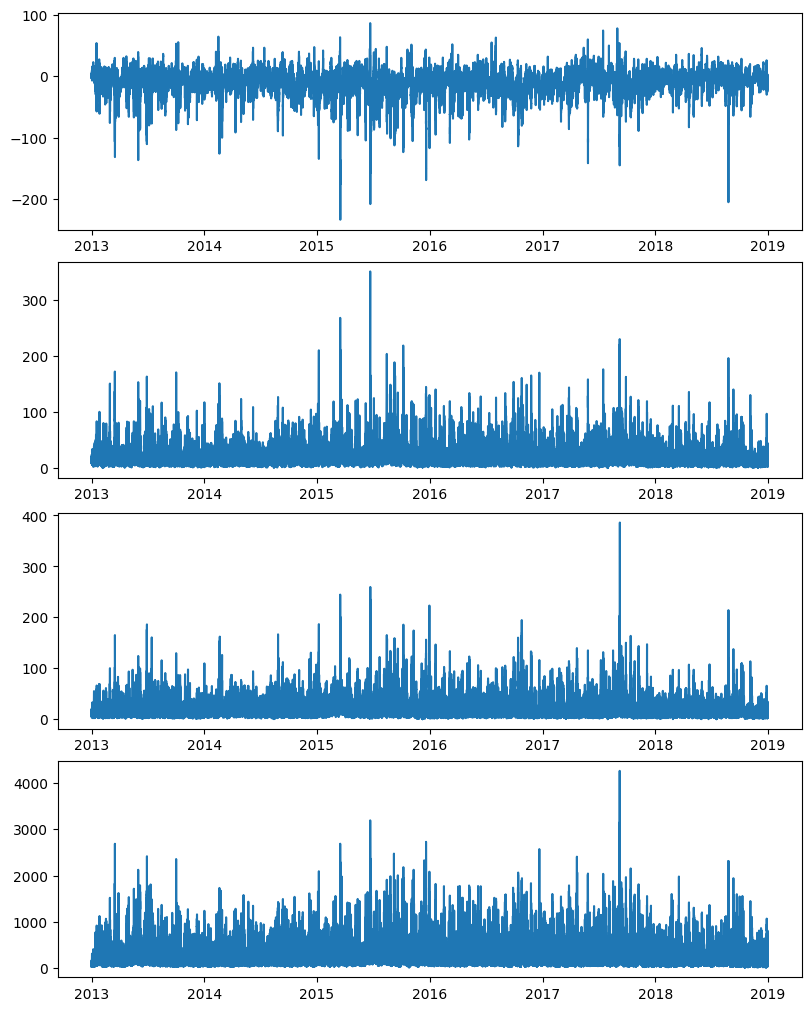

In [3]:
# Extra Code - clean solar wind data
# In case that we need to use solar wind data as input.
# Since there are some data gaps in solar wind measurements between 
# 2017-09-09 and 2017-09-12, we interpolate these data gaps.
ind_symh_1= np.where(df_symh['Datetime']=='2017-09-09 00:02:30')[0][0]
ind_symh_2= np.where(df_symh['Datetime']=='2017-09-12 00:02:30')[0][0]
for i in range(ind_symh_1, ind_symh_2):
    if (~np.isfinite (df_symh['Pressure'][i])):
        df_symh.loc[i,'Pressure'] = df_symh.loc[i-1,'Pressure']
        df_symh.loc[i,'Density'] = df_symh.loc[i-1,'Density']
        df_symh.loc[i,'Vx'] = df_symh.loc[i-1,'Vx']
        df_symh.loc[i,'Bz'] = df_symh.loc[i-1,'Bz']
        #df_symh['Pressure'][i] = df_symh['Pressure'][i-1]
        #df_symh['Bz'][i] = df_symh['Bz'][i-1]
        #df_symh['Vx'][i] = df_symh['Vx'][i-1]
        #df_symh['Density'][i] = df_symh['Density'][i-1]

# Extra code - visualize SymH index
tstr_plot_begin='2013-01-01 00:00:00'
tstr_plot_end='2019-01-01 00:00:00'
indt1_symh=np.where(df_symh['Datetime'] >= tstr_plot_begin)
indt1_symh=indt1_symh[0][0]
indt2_symh=np.where(df_symh['Datetime'] <= tstr_plot_end)
indt2_symh=indt2_symh[0][-1]+1

tarr_dt=df_symh['Datetime'].astype('datetime64[ns]')[indt1_symh:indt2_symh].reset_index(drop=True)
fig1, ax1 = plt.subplots(4,1, constrained_layout=True)
fig1.set_size_inches(8, 10)
ax1[0].plot(tarr_dt,df_symh["SymH"][indt1_symh:indt2_symh])
ax1[1].plot(tarr_dt,df_symh["AsyH"][indt1_symh:indt2_symh])
ax1[2].plot(tarr_dt,df_symh["AsyD"][indt1_symh:indt2_symh])
ax1[3].plot(tarr_dt,df_symh["SME"][indt1_symh:indt2_symh])


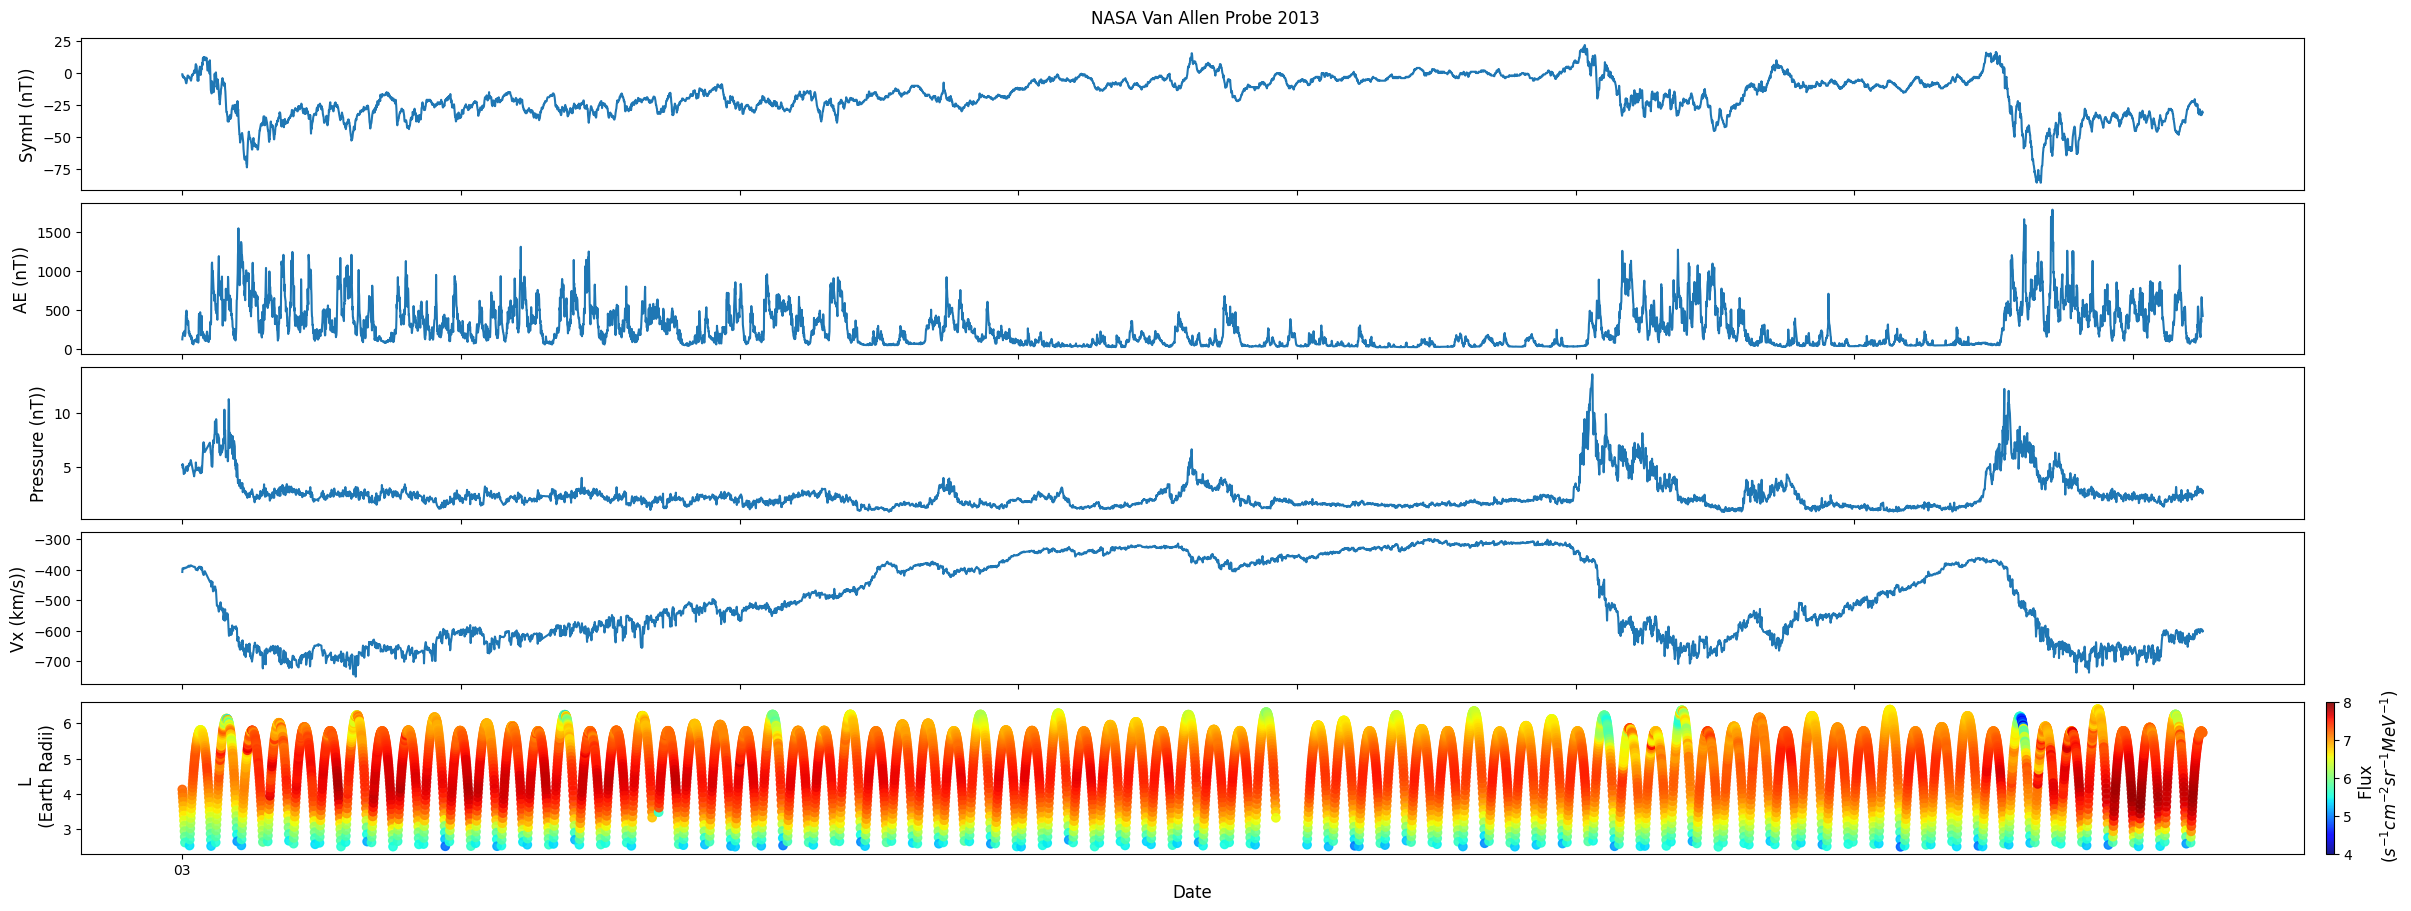

In [4]:

from matplotlib import ticker, cm
import matplotlib.dates as mdates
import matplotlib.colors as colors
tstr1='2017-03-01 00:00:00'
tstr2='2017-03-30 00:00:00'
ind_t1 = np.where((df_coord['Datetime'] >= tstr1))[0][0]
ind_t2 = np.where((df_coord['Datetime'] >= tstr2))[0][0]
ind_s1 = np.where((df_symh['Datetime'] >= tstr1))[0][0]
ind_s2 = np.where((df_symh['Datetime'] >= tstr2))[0][0]
tarr_dt= df_coord['Datetime'][ind_t1:ind_t2].astype('datetime64[ns]').reset_index(drop=True)
L_arr  = df_coord['L'][ind_t1:ind_t2].reset_index(drop=True)
#flux_18 = df_flux['46'][ind_t1:ind_t2].reset_index(drop=True)
#flux_18 = df_flux['15237'][ind_t1:ind_t2].reset_index(drop=True)
flux_18 = df_flux['148'][ind_t1:ind_t2].reset_index(drop=True)

fs = 12 #fontsize
fig1, axs = plt.subplots(5,1,constrained_layout=True)
fig1.set_size_inches(24,9)
fig1.suptitle('NASA Van Allen Probe 2013', fontsize=fs)

axs[0].plot(tarr_dt,df_symh['SymH'][ind_s1:ind_s2].reset_index(drop=True))
axs[0].tick_params(axis='x',labelbottom=False) # Labels along the bottom edge are off
axs[0].set_ylabel('SymH (nT))',fontsize=fs)
#axs[0].set_yscale('log')

axs[1].plot(tarr_dt,df_symh['SME'][ind_s1:ind_s2].reset_index(drop=True))
axs[1].tick_params(axis='x',labelbottom=False) # Labels along the bottom edge are off
axs[1].set_ylabel('AE (nT))',fontsize=fs)


axs[2].plot(tarr_dt,df_symh['Pressure'][ind_s1:ind_s2].reset_index(drop=True))
axs[2].tick_params(axis='x',labelbottom=False) # Labels along the bottom edge are off
axs[2].set_ylabel('Pressure (nT))',fontsize=fs)

axs[3].plot(tarr_dt,df_symh['Vx'][ind_s1:ind_s2].reset_index(drop=True))
axs[3].tick_params(axis='x',labelbottom=False) # Labels along the bottom edge are off
axs[3].set_ylabel('Vx (km/s))',fontsize=fs)

#s1 = axs[1].scatter(tarr_dt,L_arr,c=flux_18, cmap=cm.jet, alpha=0.9,  norm=colors.LogNorm(vmin=1, vmax=9))
s1 = axs[4].scatter(tarr_dt,L_arr,c=flux_18, cmap=cm.jet, alpha=0.9,  norm=colors.Normalize(vmin=4, vmax=8))
axs[4].xaxis.set_major_locator(mdates.MonthLocator())
#axs[1].xaxis.set_minor_locator(mdates.HourLocator())
axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%m'))
axs[4].set_xlabel('Date',fontsize=fs)
axs[4].set_ylabel('L \n (Earth Radii)',fontsize=fs)

cbar = fig1.colorbar(s1,ax = axs[4],fraction = 0.02, pad=0.01)
cbar.set_label('Flux \n ($s^{-1}cm^{-2}sr^{-1}MeV^{-1}$)',fontsize=fs)
plt.show()


In [5]:
#Check Nan and Inf
datetime_arr=df_coord["Datetime"]
coord0 = df_coord.iloc[:,1:5]
symh_ae= torch.tensor(df_symh.iloc[:,[11,12,13,14]].values,dtype=torch.float32)
flux_data = torch.tensor(df_flux.iloc[:,1:].values,dtype=torch.float32)

#Coord0: Xsm,Ysm,Zsm,L, MLT，LAT
#Coord1: L, cos(theta),sin(theta),Lat; all are scaled linearly to [-1,1]
LL0 = torch.tensor(df_coord.iloc[:,4].values,dtype=torch.float32)
MLT0 = torch.tensor(df_coord.iloc[:,5].values,dtype=torch.float32)
LAT0 = torch.tensor(df_coord.iloc[:,6].values,dtype=torch.float32)
cost0=np.cos(MLT0*np.pi/12.0)
sint0=np.sin(MLT0*np.pi/12.0)
coord1 = torch.stack(((LL0-2.5)/(6.57-2.5)*2.0-1.0,cost0,sint0,LAT0/0.35),dim=1)#L_max = 6.57, L_min = 2.5, Lat_max = 0.35 rad
coord1.shape


torch.Size([1262016, 4])

In [6]:

# Scale geomagnetic indices
Xlow =torch.tensor([-100.,    0.,    0.,     0.])
Xhigh=torch.tensor([  20.,  100.,  100.,  1500.]) 

for i in range(len(Xlow)):
    symh_ae[:,i] = (symh_ae[:,i] -Xlow[i])/(Xhigh[i]-Xlow[i])*2.0-1.0

In [7]:
symh_ae.shape

torch.Size([736416, 4])

In [8]:



## Create tsec_arr
N_symh,M_symh=symh_ae.shape
ind1_symh=np.where(df_symh["Datetime"] == df_coord["Datetime"][0])
ind1_symh=ind1_symh[0][0]
#print(df_symh.iloc[ind1_symh:N_symh,2])
xx=df_symh.iloc[ind1_symh:]
N_sample_per_probe=N_symh-ind1_symh
N_sample_total=N_sample_per_probe*len(probes)
df_symh
tsec_0=time_double(datetime_arr[0])
tsec_1=time_double(datetime_arr[N_sample_per_probe-1])
delta_t =time_double(datetime_arr[1])-time_double(datetime_arr[0])
tsec_arr=np.arange(N_sample_per_probe)*delta_t+tsec_0



In [9]:
## This section generate the feature matrix and data matrix X_y_all, which contains the solar wind and 
#  geomagnectic indics as inputs

# Time reslution is set to be two hours
Ind_t_symh=np.arange(-10*24*12,1,24)

N_feature_history=Ind_t_symh.size
n_col_coord=coord1.shape[1]
n_col_flux=flux_data.shape[1]

N_ftr=N_feature_history*M_symh
X = torch.zeros(N_sample_total,N_ftr+n_col_coord)#,dtype='float32')
# X =np.zeros([N_sample_total,(N_ftr+n_col_coord)],dtype='float32')

X[0:N_sample_total,N_ftr:(N_ftr+n_col_coord)]=coord1

Mat_symh_ind=np.zeros([N_sample_total,N_feature_history])
for k in range(N_feature_history):
    X[0:N_sample_per_probe,(k*M_symh):(k+1)*M_symh]=symh_ae[(ind1_symh+Ind_t_symh[k]):(N_symh+Ind_t_symh[k]),:]
    if (len(probes)==2):
        X[N_sample_per_probe:N_sample_total,(k*M_symh):(k+1)*M_symh]=symh_ae[(ind1_symh+Ind_t_symh[k]):(N_symh+Ind_t_symh[k]),:]

# X columns are as follows:
# 0       1       2       3     ... 7      8       9       10      11    ...  15     16     ...  1020, 1021, 1022, 1023, 1024,     1025,     1026      1027
# SymH_1  AsyH_1  AsyD_1  SME_1 ... Bz_1;  SymH_2  AsyH_2  AsyD_2  SME_2 ...  Bz_2;  Symh_3 ...  X   , Y,    Z,    L,    rept[:,0] rept[:,1] rept[:,2] rept[:,3]
# SymH-240 AsyH-240 ...                 ;  SymH-238 AsyH-238

In [10]:
# Mark Train, valid and test samples
# 0: train; 1:valid; 2:test


#Time range for test data set
tstr_test_begin='2017-01-01'
tstr_test_end='2018-01-01'
tsec_test_begin=time_double(tstr_test_begin)
tsec_test_end=time_double(tstr_test_end)


episode_time= 86400.0*2 #daily #weekly
N_episode = np.floor((tsec_1-tsec_0)/episode_time).astype(int)
N_episode_test_begin = np.ceil((tsec_test_begin-tsec_0)/episode_time).astype(int)
N_episode_test_end   = np.ceil((tsec_test_end  -tsec_0)/episode_time).astype(int)
episodes = np.arange(N_episode)
episodes = np.delete(episodes,np.arange(N_episode_test_begin,N_episode_test_end))
#If the test set is randomly split
#episode_train_full,episode_test=train_test_split(episodes, test_size=0.01, train_size=1.0, random_state=42)
#episode_train,episode_valid=train_test_split(episode_train_full, test_size=0.2, train_size=0.8, random_state=42)
#If the test set is not specified here but later in a time range
episode_test=[]
episode_train,episode_valid=train_test_split(episodes, test_size=0.2, train_size=0.8, random_state=42)

#print(episode_train.shape)
#print(episode_valid.shape)
#print(episode_test.shape)
#print(episode_train_full.shape)
Sample_per_episode=int(episode_time/delta_t) #576


In [11]:

# train set
ind_train=[]
for k in episode_train:
    ind_train += np.arange(k*Sample_per_episode,(k+1)*Sample_per_episode).tolist()
    if (n_probes == 2):
        ind_train += np.arange(k*Sample_per_episode+N_sample_per_probe,(k+1)*Sample_per_episode+N_sample_per_probe).tolist()

# Validation set
ind_valid=[]
for k in episode_valid:
    ind_valid +=np.arange(k*Sample_per_episode,(k+1)*Sample_per_episode).tolist()
    if (n_probes == 2):
        ind_valid +=np.arange(k*Sample_per_episode+N_sample_per_probe,(k+1)*Sample_per_episode+N_sample_per_probe).tolist()

ind_test = np.where((df_flux['Datetime'] >= tstr_test_begin) & (df_flux['Datetime'] <= tstr_test_end))[0]
np.set_printoptions(precision=3,suppress=True)
print(len(ind_train))
print(len(ind_valid))
print(len(ind_test))

# print(np.nanmax(X_y_all[:,[0,1,2,3,N_ftr,N_ftr+1,N_ftr+2,N_ftr+3]],axis=0))
# print(np.nanmin(X_y_all[:,[0,1,2,3,N_ftr,N_ftr+1,N_ftr+2,N_ftr+3]],axis=0))

840960
210816
210240


In [12]:
iek=1 # iek = 0 indicates 45 keV, iek = 1 indicates 55 keV, and so on
# iek      0     1     2     3     4      5      6      7      8     9      10    11     12     13
# energy '45', '55', '67', '82', '99', '121', '148', '181', '220', '269', '328', '400', '489', '598' keV

_,N_X=X.shape
_,N_y=flux_data.shape
print(N_X,N_y)
X_train = X[ind_train,:]
X_valid = X[ind_valid,:]
X_test = X[ind_test,:]
y_train = flux_data[ind_train,iek].unsqueeze(1)  # Ensure shape [batch_size, 1]
y_valid = flux_data[ind_valid,iek].unsqueeze(1)  # Ensure shape [batch_size, 1]
y_test = flux_data[ind_test,iek].unsqueeze(1)  # Ensure shape [batch_size, 1]

print(X_train.shape)
print(y_train.shape)
np.set_printoptions(precision=4,suppress=True)
print(X_train.max(axis=0).values[[0,1,2,3,-4,-3,-2,-1]])
print(X_train.min(axis=0).values[[0,1,2,3,-4,-3,-2,-1]])
print(X_valid.max(axis=0).values[[0,1,2,3,-4,-3,-2,-1]])
print(X_valid.min(axis=0).values[[0,1,2,3,-4,-3,-2,-1]])

488 14
torch.Size([840960, 488])
torch.Size([840960, 1])
tensor([1.3417, 6.0300, 4.1900, 3.2560, 1.0000, 1.0000, 1.0000, 0.9951])
tensor([-3.2250, -0.9600, -1.0000, -0.9707, -1.7022, -1.0000, -1.0000, -0.9953])
tensor([1.2917, 2.7800, 3.0100, 2.0560, 0.9981, 1.0000, 1.0000, 0.9950])
tensor([-3.1667, -0.9500, -0.9400, -0.9600, -1.7022, -1.0000, -1.0000, -0.9942])


In [13]:
mask_train = ~torch.isnan(X_train).any(dim=1) & ~torch.isnan(y_train).any(dim=1)
mask_valid = ~torch.isnan(X_valid).any(dim=1) & ~torch.isnan(y_valid).any(dim=1)
mask_test  = ~torch.isnan(X_test).any(dim=1)  & ~torch.isnan(y_test).any(dim=1)

In [14]:

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train[mask_train], y_train[mask_train])
valid_dataset = TensorDataset(X_valid[mask_valid], y_valid[mask_valid])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


# Training with Early Stopping
epochs = 40
n_neurons = 50
patience = 32
best_loss = float('inf')
counter = 0  # Counts epochs without improvement


In [15]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        # super.__init__() # In Python 3?
        self.model = nn.Sequential(
            nn.Linear(input_size, n_neurons),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_neurons, n_neurons),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_neurons, 1)  # Output layer
        )

    def forward(self, x):
        return self.model(x)
    

# Initialize model
input_size = X_train.shape[1]  # Number of features
model = MLP(input_size)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [16]:
print(len(train_loader))
print(len(valid_loader))

12761
3077


In [17]:
import time
train_loss_history = []
valid_loss_history = []
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            valid_loss += loss.item()

    # Compute average loss
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}, Time elapsed: {elapsed_time:.2f}s")

Epoch 1/40, Train Loss: 0.6985, Val Loss: 0.1424, Time elapsed: 8.26s
Epoch 2/40, Train Loss: 0.2058, Val Loss: 0.1314, Time elapsed: 7.55s
Epoch 3/40, Train Loss: 0.1413, Val Loss: 0.1206, Time elapsed: 7.63s
Epoch 4/40, Train Loss: 0.1267, Val Loss: 0.1174, Time elapsed: 7.81s
Epoch 5/40, Train Loss: 0.1195, Val Loss: 0.1210, Time elapsed: 7.88s
Epoch 6/40, Train Loss: 0.1144, Val Loss: 0.1108, Time elapsed: 7.48s
Epoch 7/40, Train Loss: 0.1092, Val Loss: 0.1135, Time elapsed: 7.78s
Epoch 8/40, Train Loss: 0.1056, Val Loss: 0.1039, Time elapsed: 7.63s
Epoch 9/40, Train Loss: 0.1035, Val Loss: 0.1137, Time elapsed: 8.01s
Epoch 10/40, Train Loss: 0.1004, Val Loss: 0.1040, Time elapsed: 7.73s
Epoch 11/40, Train Loss: 0.0988, Val Loss: 0.1060, Time elapsed: 7.61s
Epoch 12/40, Train Loss: 0.0970, Val Loss: 0.1006, Time elapsed: 7.84s
Epoch 13/40, Train Loss: 0.0951, Val Loss: 0.1004, Time elapsed: 7.69s
Epoch 14/40, Train Loss: 0.0940, Val Loss: 0.0964, Time elapsed: 7.58s
Epoch 15/40, Tr

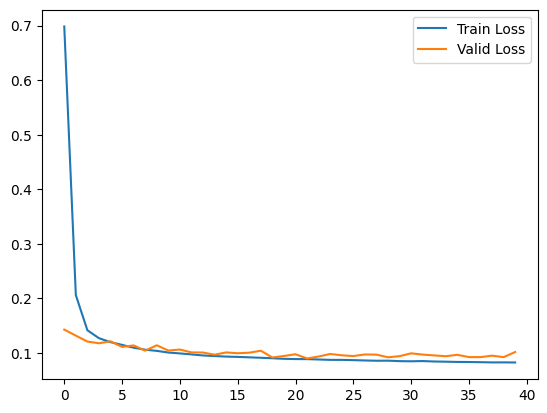

In [18]:
fig,ax = plt.subplots(1,1)
ax.plot(train_loss_history,label='Train Loss')
ax.plot(valid_loss_history,label='Valid Loss')
ax.legend()
plt.show()



(86023,)
0.07348354921873185


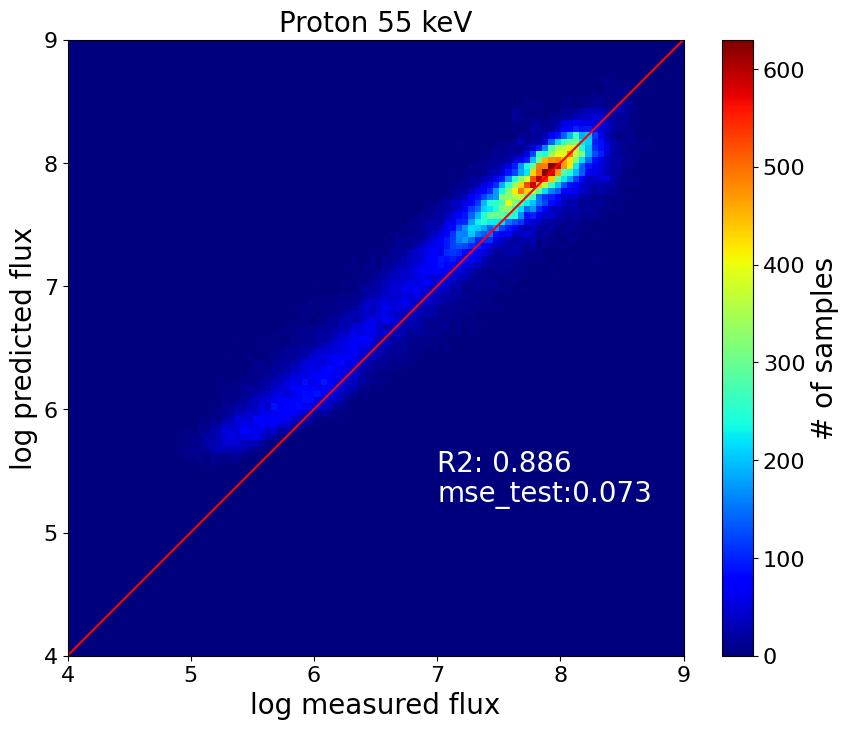

In [19]:
y_test_reshaped=y_test[mask_test].reshape([-1])
y_test_pred_reshaped = model.forward(X_test[mask_test]).reshape([-1])
y_test_pred_reshaped = y_test_pred_reshaped.detach()
dir_out = './results/'
fn1 = 'p_55_keV_15_neurons_2_layers_0_dropout_32_patience_1e-03_lr_40_epochs_32_batchsize_2025_02_27_16_25_25'
y1 = y_test_reshaped.numpy()
y2 = y_test_pred_reshaped.numpy()
lws_rbspice_correlation(y1, y2, xrange=[4,9],figname=dir_out+'corr_'+fn1,ek=df_flux.columns[iek+1])

(408345,)
0.0668485387983757


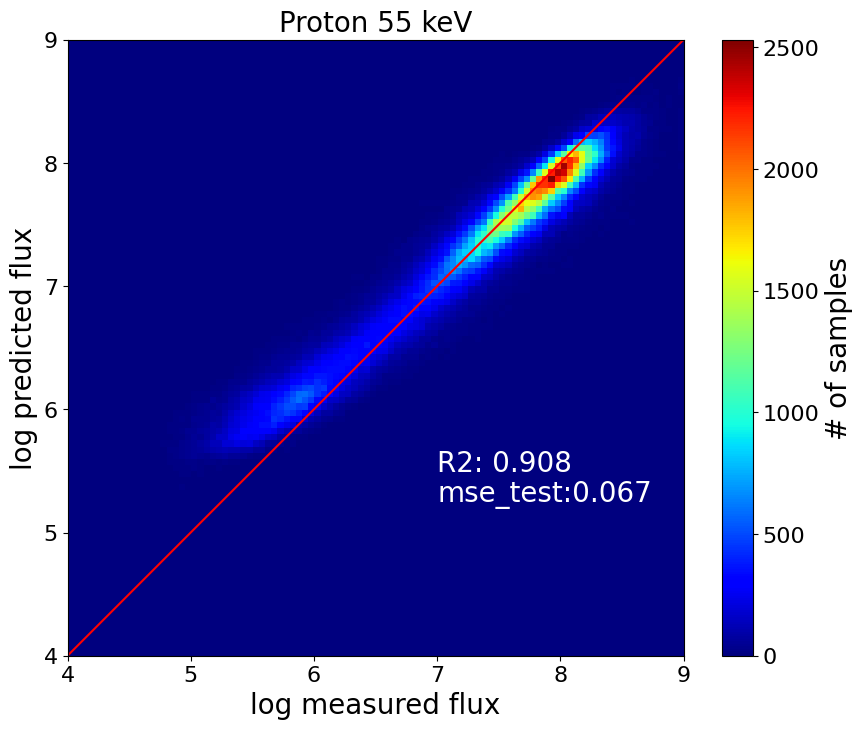

In [20]:
y_train_reshaped=y_train[mask_train].reshape([-1])
y_train_pred_reshaped = model.forward(X_train[mask_train]).reshape([-1])
y_train_pred_reshaped = y_train_pred_reshaped.detach()
dir_out = './results/'
fn1 = 'p_148_keV_15_neurons_2_layers_0_dropout_32_patience_1e-03_lr_40_epochs_32_batchsize_2025_02_27_16_25_25'
y1 = y_train_reshaped.numpy()
y2 = y_train_pred_reshaped.numpy()
lws_rbspice_correlation(y1, y2, xrange=[4,9],figname=dir_out+'corr_'+fn1,ek=df_flux.columns[iek+1])

(98442,)
0.10134604777346098


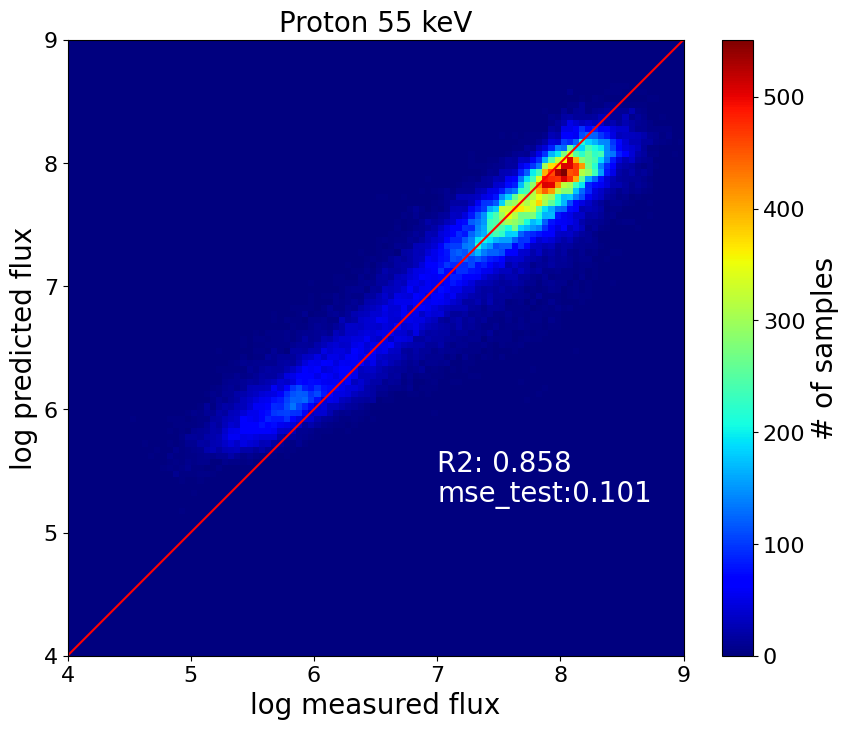

In [21]:
y_valid_reshaped=y_valid[mask_valid].reshape([-1])
y_valid_pred_reshaped = model.forward(X_valid[mask_valid]).reshape([-1])
y_valid_pred_reshaped = y_valid_pred_reshaped.detach()
dir_out = './results/'
fn1 = 'p_148_keV_15_neurons_2_layers_0_dropout_32_patience_1e-03_lr_40_epochs_32_batchsize_2025_02_27_16_25_25'
y1 = y_valid_reshaped.numpy()
y2 = y_valid_pred_reshaped.numpy()
lws_rbspice_correlation(y1, y2, xrange=[4,9],figname=dir_out+'corr_'+fn1,ek=df_flux.columns[iek+1])

In [22]:
y_test_pred_reshaped

tensor([7.8532, 7.8684, 7.8604,  ..., 6.5051, 6.5901, 6.6501])

In [25]:

y_test_pred_reshaped = model.forward(X_test).reshape([-1])
y_test_pred_reshaped = y_test_pred_reshaped.detach()
# convert to numpy array
y_test_pred_reshaped = y_test_pred_reshaped.numpy()

### Session 2: Compare the predicted flux and the measurements

In [29]:
## The following sections are to visulize the long-term variation of modeled proton flux
tstr_plot_begin='2017-01-01 00:00:00'
tstr_plot_end='2017-12-31 23:59:00'
class time_series():
    x = []
    y = []
    v = []
    ylabel = 'y'
    xlabel = 'x'
    linecolors = 'k'
    plot_style = 'plt'
    title= 'title'
    vrange=[]
    cmap='jet'

indt1_symh=np.where(df_symh['Datetime'] >= tstr_plot_begin)
indt1_symh=indt1_symh[0][0]
indt2_symh=np.where(df_symh['Datetime'] <= tstr_plot_end)
indt2_symh=indt2_symh[0][-1]+1
tarr_dt=df_symh['Datetime'].astype('datetime64[ns]')[indt1_symh:indt2_symh].reset_index(drop=True)

indt1_flux=np.where(df_flux['Datetime'][0:N_sample_per_probe] >= tstr_plot_begin)
indt1_flux=indt1_flux[0][0]
indt2_flux=np.where(df_flux['Datetime'][0:N_sample_per_probe] <= tstr_plot_end)
indt2_flux=indt2_flux[0][-1]+1

t_symh = time_series()
t_symh.x = tarr_dt
t_symh.y = df_symh['SymH'][indt1_symh:indt2_symh].reset_index(drop=True)
t_symh.ylabel = 'SymH (nT)'

t_asyh = time_series()
t_asyh.x = tarr_dt
t_asyh.y = df_symh['AsyH'][indt1_symh:indt2_symh].reset_index(drop=True)
t_asyh.ylabel = 'AsyH (nT)'

t_asyd = time_series()
t_asyd.x = tarr_dt
t_asyd.y = df_symh['AsyD'][indt1_symh:indt2_symh].reset_index(drop=True)
t_asyd.ylabel = 'AsyD (nT)'


t_sme = time_series()
t_sme.x = tarr_dt
t_sme.y = df_symh['SME'][indt1_symh:indt2_symh].reset_index(drop=True)
t_sme.ylabel = 'SME (nT)'


t_sml = time_series()
t_sml.x = tarr_dt
t_sml.y = df_symh['SML'][indt1_symh:indt2_symh].reset_index(drop=True)
t_sml.ylabel = 'SML (nT)'


t_vx= time_series()
t_vx.x = tarr_dt
t_vx.y = df_symh['Vx'][indt1_symh:indt2_symh].reset_index(drop=True)
t_vx.ylabel = 'Vx km/s'

t_density = time_series()
t_density.x = tarr_dt
t_density.y = df_symh['Density'][indt1_symh:indt2_symh].reset_index(drop=True)
t_density.ylabel='Density'

t_pflux = time_series()
t_pflux.x = tarr_dt
t_pflux.y = df_coord['L'][indt1_flux:indt2_flux].reset_index(drop=True)
t_pflux.v = df_flux.iloc[:,iek+1][indt1_flux:indt2_flux].reset_index(drop=True)
t_pflux.ylabel = 'L'
t_pflux.plot_style = 'scatter'  # 'colorline'
t_pflux.vrange = [4, 9]

t_flux=[]
for i in range(df_flux.columns.shape[0]):
    t_flux1 = time_series()
    t_flux1.x = tarr_dt
    t_flux1.y = df_coord['L'][indt1_flux:indt2_flux].reset_index(drop=True)
    t_flux1.v = df_flux.iloc[:,(i+1):(i+2)][indt1_flux:indt2_flux].reset_index(drop=True)
    t_flux1.ylabel = 'L'
    t_flux1.plot_style = 'scatter'  # 'colorline'
    t_flux1.vrange = [4, 9]

    t_flux.append(t_flux1)
    del t_flux1

In [31]:
indt1_test=np.where((df_coord['Datetime'][ind_test] >= tstr_plot_begin) & (ind_test < df_coord.shape[0]/2)) 
# probe A: ind_test < df_coord.shape[0]/2; Probe B: # probe A: ind_test >= df_coord.shape[0]/2
indt2_test=np.where((df_coord['Datetime'][ind_test] <= tstr_plot_end  ) & (ind_test < df_coord.shape[0]/2))
indt1_test=indt1_test[0][0]
indt2_test=indt2_test[0][-1]
ind_test_plot=ind_test[indt1_test:indt2_test]
tarr_test=df_coord['Datetime'].astype('datetime64[ns]')[ind_test_plot]#.reset_index(drop=True)

t_y_test = time_series()
t_y_test.x = tarr_test
t_y_test.y = df_coord['L'][ind_test_plot]
t_y_test.v = df_flux.iloc[:,iek+1][ind_test_plot]#.reset_index(drop=True)
t_y_test.ylabel = 'L'
t_y_test.plot_style = 'scatter' #'colorline'
t_y_test.vrange=[3,8]
t_y_test.title='Data'
t_y_test.cmap='jet'

t_y_pred = time_series()
t_y_pred.x = tarr_test
t_y_pred.y = df_coord['L'][ind_test_plot]
t_y_pred.v =  y_test_pred_reshaped[0:ind_test_plot.size]
t_y_pred.ylabel = 'L'
t_y_pred.plot_style = 'scatter' #'colorline'
t_y_pred.vrange=[3,8]
t_y_pred.title='Prediction'
t_y_pred.cmap='jet'

t_y_diff = time_series()
t_y_diff.x = tarr_test
t_y_diff.y = df_coord['L'][ind_test_plot]
t_y_diff.v =  y_test_pred_reshaped[0:ind_test_plot.size]-df_flux.iloc[:,iek+1][ind_test_plot].reset_index(drop=True)
t_y_diff.ylabel = 'L'
t_y_diff.plot_style = 'scatter' #'colorline'
t_y_diff.vrange=[-2,2]
t_y_diff.title='Prediction - Data'
t_y_diff.cmap='bwr'

In [32]:
t_y_test.vrange=[4,9]
t_y_pred.vrange=[4,9]

<Figure size 1800x1400 with 0 Axes>

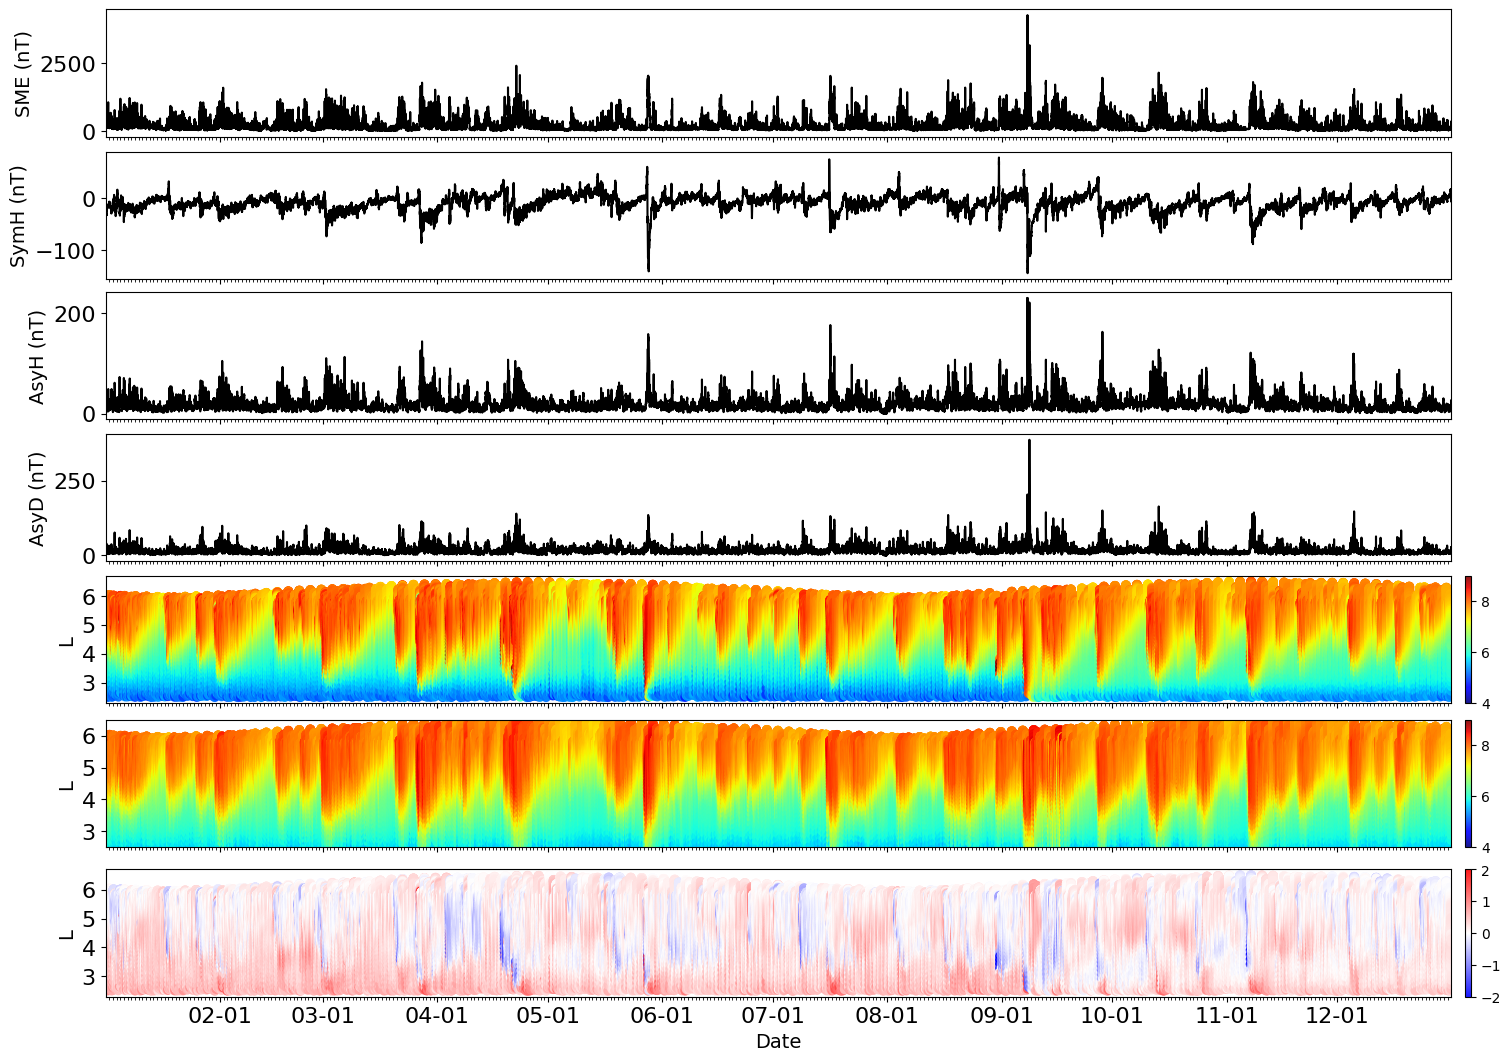

In [35]:
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42
fig5=plt.figure(figsize=(18, 14),facecolor='white')   

obj_arr = [t_sme,t_symh,t_asyh,t_asyd,t_y_test,t_y_pred,t_y_diff]
n_subfig= len(obj_arr)

ax_x0=0.2
ax_y0=0.2
ax_xw=0.7
ax_yw=0.7
ax_dy_gap=0.01
ax_dy1=(ax_yw+ax_dy_gap) / n_subfig 
ax_dy0=ax_dy1-ax_dy_gap
fs_label=14

fig5, axs = plt.subplots(n_subfig,1, constrained_layout=True)
fig5.set_size_inches(15, 10.5)

for k in range(n_subfig):
    obj0=obj_arr[k]

    if obj0.plot_style == 'plt':
        s1=axs[k].plot(obj0.x,obj0.y,c=obj0.linecolors)
    elif obj0.plot_style == 'scatter':
        if not obj0.vrange:
            s1=axs[k].scatter(obj0.x,obj0.y,c=obj0.v, cmap=obj0.cmap,alpha=0.9)
        else:
            s1=axs[k].scatter(obj0.x,obj0.y,c=obj0.v, cmap=obj0.cmap,alpha=0.9,vmin=obj0.vrange[0],vmax=obj0.vrange[1])
        axs[k].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
        fig5.colorbar(s1, ax=axs[k],fraction=0.02,pad=0.01)
        
    axs[k].set_ylabel(obj0.ylabel,fontsize=fs_label)
    
    if k !=n_subfig-1:
        axs[k].tick_params(axis='x',labelbottom=False) # labels along the bottom edge are off
    else:
        axs[k].tick_params(axis='x',labelbottom=True) # labels along the bottom edge are on
    
    n_ts=obj0.x.shape[0]
    delta_t_days=obj0.x.reset_index(drop=True)[n_ts-1]-obj0.x.reset_index(drop=True)[0]
    if ( delta_t_days < dt.timedelta(days=30) ):
        axs[k].xaxis.set_major_locator(mdates.DayLocator())
        axs[k].xaxis.set_minor_locator(mdates.HourLocator())
        axs[k].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    else:
        axs[k].xaxis.set_major_locator(mdates.MonthLocator())
        axs[k].xaxis.set_minor_locator(mdates.DayLocator())
        axs[k].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axs[k].tick_params(axis='both', which='major', labelsize=16)
    axs[k].tick_params(axis='both', which='minor', labelsize=12)
    axs[k].set_xlim(obj0.x.iloc[0],obj0.x.iloc[-1])

axs[5].set_ylim(2.5,6.5)
axs[k].set_xlabel('Date',fontsize=fs_label)
figname=dir_out+'long_term_'+fn1
#fig5.savefig(figname+"_6.pdf",format='pdf')
fig5.savefig(figname+"_6.png", format="png", dpi=300)

plt.show()

### Use the RCPANN model to produce global distribution of proton fluxes
This session shows how to use the RCPANN model to produce a global distribution of spin-averaged proton flux at a specific energy, which is stored in "y_pred_matrix". The data y_pred_matrix is the equatorial proton flux in the Xrange of [-6.5, 6.5] and Yrange of [-6.5, 6.5], but only those in the in the radial distance range [2.5, 6.5] are trustful. 

In [14]:
# Definitions for Global distribution
xrange=[-6.5,6.5]
yrange=xrange
delta = 0.1
NX=int((xrange[1]-xrange[0])/delta)
NY=int((yrange[1]-yrange[0])/delta)
extent = (xrange[0], xrange[1], yrange[0], yrange[1])
x = np.arange(xrange[0], xrange[1], delta)
y = np.arange(yrange[0], yrange[1], delta)
XX, YY = np.meshgrid(x, y)


XX_flat=XX.flatten()
YY_flat=YY.flatten()
RR_flat=np.sqrt(XX_flat**2+YY_flat**2)
sint_flat = -YY_flat/RR_flat #Since we defined sint = sin(MLT/12*!pi)
cost_flat = -XX_flat/RR_flat
LAT_flat = XX_flat*0.0
#zero_glb=XX_flat*0.0
LL_flat=(RR_flat-2.5)/(6.57-2.5)*2.0-1.0 # scale from [2.5,6.57] to [0,1]

coord_glb=np.concatenate((LL_flat.reshape([-1,1]),cost_flat.reshape([-1,1]),sint_flat.reshape([-1,1]),LAT_flat.reshape([-1,1])), axis=1)
extent = (xrange[0], xrange[1], yrange[0], yrange[1])
x = np.arange(xrange[0], xrange[1], delta)
y = np.arange(yrange[0], yrange[1], delta)
X, Y = np.meshgrid(x, y)
vmax=9.0
vmin=5.0
norm = mpl.cm.colors.Normalize(vmax=vmax, vmin=vmin)
cmap = mpl.cm.jet

In [15]:
# Compare the period 2015-03-15/12 to 2015-03-20/00
tstr1='2017-03-01 00:02:00'
tstr2='2017-03-04 23:57:00'
indt1_symh=np.where(df_symh['Datetime'] >= tstr1)
indt1_symh=indt1_symh[0][0]
indt2_symh=np.where(df_symh['Datetime'] >= tstr2)
indt2_symh=indt2_symh[0][0]+1
tarr_dt=df_symh['Datetime'].astype('datetime64')[indt1_symh:indt2_symh].reset_index(drop=True)


indt1_coord=np.where(df_coord['Datetime'] >= tstr1)
indt1_coord=indt1_coord[0][0]
indt2_coord=np.where(df_coord['Datetime'] >= tstr2)
indt2_coord=indt2_coord[0][0]+1



In [2]:
tarr_dt[200]

NameError: name 'tarr_dt' is not defined

529/529 [==============================] - 0s 545us/step


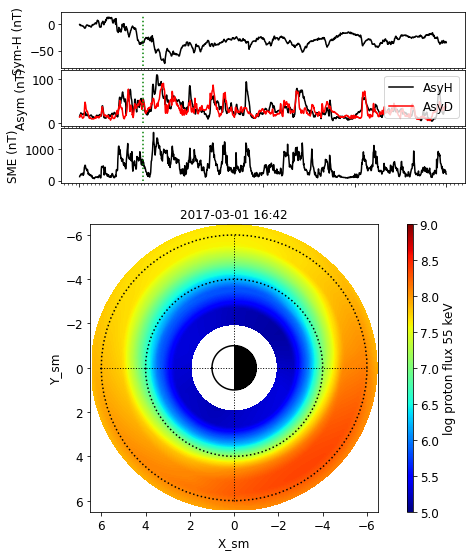

In [17]:

mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42

ax_x0=0.2
ax_dx=0.7
ax_dy=0.10
ax_dy_1=0.097
ax_y0=0.55

for k in [200]: #(0,tarr_dt.size,4): [32,200,272]
    tbar=tarr_dt[k]
    indt_glb_1=k+indt1_coord
    fig4=plt.figure(figsize=(8,8),facecolor='white')   
    
    n_fig=4
    #fig = plt.figure(figsize=(18, 14),facecolor='white')   
    fs_label=12
    fs_major=12
    fs_minor=9

    ax1=fig4.add_subplot(n_fig,1,1)
    ax1.set_position([ax_x0,ax_y0+3*ax_dy,ax_dx,ax_dy_1])
    ax1.plot(tarr_dt,df_symh['SymH'][indt1_symh:indt2_symh],'k')
    y_min, y_max = ax1. get_ylim()
    ax1.plot([tbar,tbar],[y_min,y_max],':g')
    ax1.set_ylabel("Sym-H (nT)",fontsize=fs_label)
    ax1.tick_params(axis='x',labelbottom=False) # labels along the bottom edge are off

    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_minor_locator(mdates.HourLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.tick_params(axis='both', which='major', labelsize=fs_major)
    ax1.tick_params(axis='both', which='minor', labelsize=fs_minor)

    ax2=fig4.add_subplot(n_fig,1,2)
    ax2.set_position([ax_x0,ax_y0+2*ax_dy,ax_dx,ax_dy_1])
    ax2.plot(tarr_dt,df_symh['AsyH'][indt1_symh:indt2_symh],'k')
    ax2.plot(tarr_dt,df_symh['AsyD'][indt1_symh:indt2_symh],'r')
    y_min, y_max = ax2. get_ylim()
    ax2.plot([tbar,tbar],[y_min,y_max],':g')
    ax2.set_ylabel("Asym (nT)",fontsize=fs_label)
    ax2.tick_params(axis='x', labelbottom=False) # labels along the bottom edge are off

    ax2.xaxis.set_major_locator(mdates.DayLocator())
    ax2.xaxis.set_minor_locator(mdates.HourLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax2.tick_params(axis='both', which='major', labelsize=fs_major)
    ax2.tick_params(axis='both', which='minor', labelsize=fs_minor)
    ax2.legend(('AsyH', 'AsyD'), loc='upper right',fontsize=fs_label)


    ax3=fig4.add_subplot(n_fig,1,3)
    ax3.set_position([ax_x0,ax_y0+1*ax_dy,ax_dx,ax_dy_1])
    ax3.plot(tarr_dt,df_symh['SME'][indt1_symh:indt2_symh],'k')
    y_min, y_max = ax3. get_ylim()
    ax3.plot([tbar,tbar],[y_min,y_max],':g')
    ax3.set_ylabel("SME (nT)",fontsize=fs_label)
    ax3.tick_params(axis='x', labelbottom=False) # labels along the bottom edge are off

    ax3.xaxis.set_major_locator(mdates.DayLocator())
    ax3.xaxis.set_minor_locator(mdates.HourLocator())
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax3.tick_params(axis='both', which='major', labelsize=fs_major)
    ax3.tick_params(axis='both', which='minor', labelsize=fs_minor)

    ax3.xaxis.set_major_locator(mdates.DayLocator())
    ax3.xaxis.set_minor_locator(mdates.HourLocator())
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax3.tick_params(axis='both', which='major', labelsize=fs_major)
    ax3.tick_params(axis='both', which='minor', labelsize=fs_minor)



    #Subfigure 4
    X_1=X_y_all[indt_glb_1,0:N_ftr].copy()
    X_1_mat=np.matmul(np.ones([NX*NY,1]),X_1.reshape([1,len(X_1)]))
    X_glb=np.concatenate((X_1_mat,coord_glb),axis=1)
    y_glb_pred=model.predict(X_glb)
    y_pred_matrix=y_glb_pred[:,0].reshape([NX,NY])

    ax0=fig4.add_subplot(5,1,5)
    ax0.set_position([0.25,0.08,0.5,0.5])
    im = ax0.contourf(X, Y, y_pred_matrix,  256,cmap=mpl.cm.jet,vmax=vmax,vmin=vmin)

    #Set L>6.5 and L<2 blank
    theta2=np.arange(0,2.01*np.pi,0.02)
    r2=np.arange(6.5,9.5,0.1)
    R,THETA=np.meshgrid(r2,theta2)
    X2=R*np.cos(THETA)
    Y2=R*np.sin(THETA)
    im3=ax0.contourf(X2,Y2,X2*0+1.0,10,cmap=mpl.cm.cubehelix,vmax=1.0,vmin=0.0)
    r2=np.arange(0.0,2.0,0.1)
    R,THETA=np.meshgrid(r2,theta2)
    X2=R*np.cos(THETA)
    Y2=R*np.sin(THETA)
    im4=ax0.contourf(X2,Y2,X2*0+1.0,10,cmap=mpl.cm.cubehelix,vmax=1.0,vmin=0.0)


    #Add Earth
    theta=np.arange(0,2.01*np.pi,0.1)
    ax0.plot(np.cos(theta),np.sin(theta),'k')
    r=np.arange(0,1.1,0.1)
    theta1=np.arange(0.5*np.pi,1.5*np.pi,0.02)
    R,THETA=np.meshgrid(r,theta1)
    X1=R*np.cos(THETA)
    Y1=R*np.sin(THETA)
    im2=ax0.contourf(X1,Y1,X1*0+0.0,10,cmap=mpl.cm.cubehelix,vmax=1.0,vmin=0.0)
    #Add 0, 6, 12, 18 sectors and L=4,6
    ax0.plot([-6,6],[0,0],':k',linewidth=1)
    ax0.plot([0,0],[-6,6],':k',linewidth=1)
    ax0.plot(6*np.cos(theta),6*np.sin(theta),':k')
    ax0.plot(4*np.cos(theta),4*np.sin(theta),':k')

    #ax0.set_title('Proton 7.1 keV',fontsize=20)
    ax0.set_xlabel("X_sm",fontsize=fs_label)
    ax0.set_ylabel("Y_sm",fontsize=fs_label)
    ax0.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    ax0.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    ax0.tick_params(axis='both', which='major', labelsize=fs_label)
    ax0.tick_params(axis='both', which='minor', labelsize=fs_label)
    plt.axis('equal')
    ax0.set_xlim([-6.5,6.5])
    ax0.set_ylim(-6.5,6.5)
    ax0.invert_xaxis()
    ax0.invert_yaxis()

    # Add colorbar
    cax = plt.axes([0.8, 0.08, 0.01, 0.5])
    cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax0,cax=cax)
    cbar.ax.tick_params(labelsize=fs_label)
    cbar.set_label('log proton flux '+str(df_flux.columns[iek+1])+' keV', fontsize=fs_label)
    ax0.set_title(tbar.strftime("%Y-%m-%d %H:%M"),fontsize=fs_label)
    dir_out=dir0+'/lws_results/rbspice/p_'+str(df_flux.columns[iek+1])+'_keV/global8/'
    os.makedirs(dir_out, exist_ok = True) 
    plt.savefig(dir_out+"proton_'+str(df_flux.columns[iek+1])+'_kev_global"+str(k)+".png", format="png", dpi=300)
    #plt.savefig(dir_out+"proton_55_kev_global"+str(k)+".pdf",format='pdf')
    #plt.show()
